In [16]:
# データ準備

import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder


## データ準備
df = sns.load_dataset('titanic')
df.dropna(inplace=True)
# X, yを作成
X = df.drop(['survived', 'alive'], axis=1)
y = df['survived']
# ラベルエンコーディング
oe = OrdinalEncoder()
oe.set_output(transform='pandas')
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
X[cat_cols] = oe.fit_transform(X[cat_cols])

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## XGBoost

In [2]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.01, 
              eval_metric="auc", 
              early_stopping_rounds=10, 
              importance_type="total_gain",
              random_state=0)

xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-auc:0.85497
[1]	validation_0-auc:0.85497
[2]	validation_0-auc:0.85497
[3]	validation_0-auc:0.86298
[4]	validation_0-auc:0.86298
[5]	validation_0-auc:0.86058
[6]	validation_0-auc:0.86058
[7]	validation_0-auc:0.86058
[8]	validation_0-auc:0.86058
[9]	validation_0-auc:0.86538
[10]	validation_0-auc:0.86378
[11]	validation_0-auc:0.86538
[12]	validation_0-auc:0.86538
[13]	validation_0-auc:0.86378
[14]	validation_0-auc:0.87340
[15]	validation_0-auc:0.86699
[16]	validation_0-auc:0.87340
[17]	validation_0-auc:0.87500
[18]	validation_0-auc:0.87340
[19]	validation_0-auc:0.87019
[20]	validation_0-auc:0.86699
[21]	validation_0-auc:0.87019
[22]	validation_0-auc:0.87019
[23]	validation_0-auc:0.87019
[24]	validation_0-auc:0.87019
[25]	validation_0-auc:0.87019
[26]	validation_0-auc:0.86699


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type='total_gain',
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [3]:
from sklearn.metrics import roc_auc_score
y_pred_xgb = xgb.predict_proba(X_test)
print(f"Xgboost AUC: {roc_auc_score(y_test, y_pred_xgb[:, 1])}")

Xgboost AUC: 0.875


In [4]:
xgb.feature_importances_

array([0.        , 0.        , 0.1168234 , 0.00336676, 0.        ,
       0.15797192, 0.        , 0.        , 0.        , 0.64561296,
       0.04408471, 0.        , 0.03214021], dtype=float32)

<AxesSubplot:>

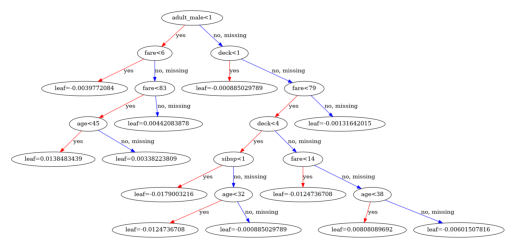

In [5]:
import xgboost
xgboost.plot_tree(xgb, num_trees=0)

## LightGBM

In [6]:
import lightgbm as lgb

In [17]:
lgbmc = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)
eval_set = [(X_test, y_test)]

# iter時に実行する関数を格納
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())

lgbmc.fit(X_train, y_train, eval_set = eval_set, callbacks=callbacks)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 84, number of negative: 43
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total

LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

In [20]:
y_pred_lgbmc = lgbmc.predict_proba(X_test)
print(f"light_gbm AUC: {roc_auc_score(y_test, y_pred_lgbmc[:, 1])}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
light_gbm AUC: 0.9383012820512822


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

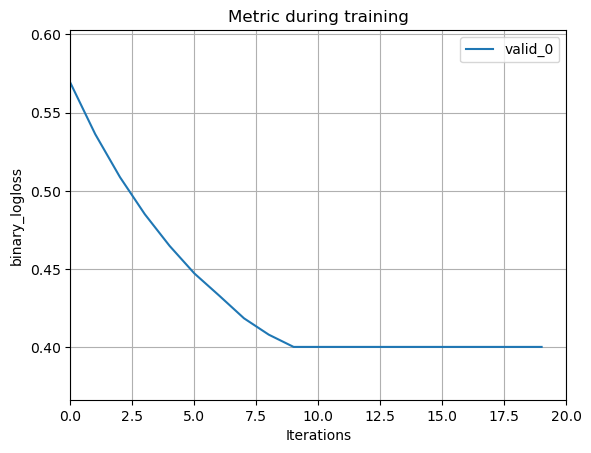

In [21]:
# 学習曲線
lgb.plot_metric(lgbmc)

<AxesSubplot:>

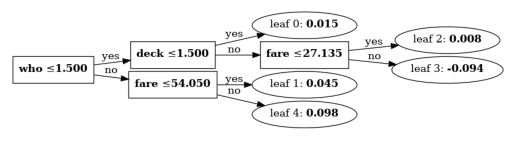

In [23]:
lgb.plot_tree(lgbmc, tree_index=-1)

<AxesSubplot:>

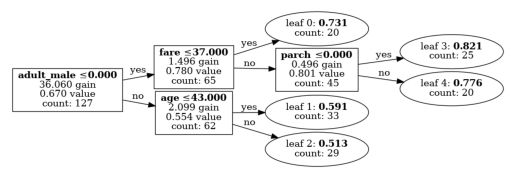

In [24]:
lgb.plot_tree(lgbmc, tree_index=0,  show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])